<a href="https://colab.research.google.com/github/HazemmoAlsady/Sentimental_Analysis/blob/main/RNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense


In [40]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/twitter_reviews.csv")
df.head()


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [41]:
# Correct number of columns → 4 columns only
df.columns = ['id', 'category', 'label', 'text']

# Use only label + text
df = df[['label', 'text']]

df = df.dropna()

print(df.head())
print(df.columns)

      label                                               text
0  Positive  I am coming to the borders and I will kill you...
1  Positive  im getting on borderlands and i will kill you ...
2  Positive  im coming on borderlands and i will murder you...
3  Positive  im getting on borderlands 2 and i will murder ...
4  Positive  im getting into borderlands and i can murder y...
Index(['label', 'text'], dtype='object')


In [42]:
# 3) Quick label value check and optional cleaning
print("\nLabel value counts:")
print(df['label'].value_counts())

# If labels contain leading/trailing spaces or inconsistent case -> normalize
df['label'] = df['label'].astype(str).str.strip()


Label value counts:
label
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


# **PreProcessing**

In [43]:
# 4) Text cleaning function
def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = re.sub(r'http\S+', '', t)          # remove URLs
    t = re.sub(r'@\w+', '', t)             # remove mentions
    t = re.sub(r'#\w+', '', t)             # remove hashtags
    t = re.sub(r"[^A-Za-z ]+", " ", t)     # keep only letters and spaces
    t = t.lower()
    t = re.sub(r'\s+', ' ', t).strip()
    return t

df['clean_text'] = df['text'].apply(clean_text)

# **Encoding**

In [44]:
# 5) Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
print("\nEncoded classes:", list(le.classes_))
# Example: ['Negative', 'Neutral', 'Positive']  -> indices [0,1,2]


Encoded classes: ['Irrelevant', 'Negative', 'Neutral', 'Positive']


In [45]:
# Optional: If you want final output Good/Not Good mapping
# We'll map: Positive -> Good, else -> Not Good
def to_good_notgood(label_str):
    if label_str.lower() == 'positive':
        return 'Good'
    else:
        return 'Not Good'


# **Tokenization**

In [46]:
# 6) Tokenization & padding
max_words = 20000   # vocab size
max_len = 40        # sequence length (tweets are short)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

y = df['label_enc'].values

# **Split data to Train/Test**

In [47]:
# 7) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# **RNN Model**

In [52]:
from tensorflow.keras import Input

model = Sequential()

# Add input layer explicitly
model.add(Input(shape=(max_len,)))

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=128))

# RNN layer
model.add(SimpleRNN(128))

# Output layer
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 40, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,412 (9.89 MB)

 Trainable params: 2,593,412 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=12,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

Epoch 1/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.4444 - loss: 1.2292 - val_accuracy: 0.6956 - val_loss: 0.7983
Epoch 2/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.8027 - loss: 0.5575 - val_accuracy: 0.7629 - val_loss: 0.6521
Epoch 3/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.8968 - loss: 0.3039 - val_accuracy: 0.8036 - val_loss: 0.5707
Epoch 4/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.9296 - loss: 0.2062 - val_accuracy: 0.7886 - val_loss: 0.6114
Epoch 5/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.9420 - loss: 0.1641 - val_accuracy: 0.7828 - val_loss: 0.6840
Epoch 6/12
370/370 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.9504 - loss: 0.1352 - val_accuracy: 0.7732 - val_loss: 0.7261


# **Evaluation**

In [54]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


Test Loss: 0.5765
Test Accuracy: 0.7959


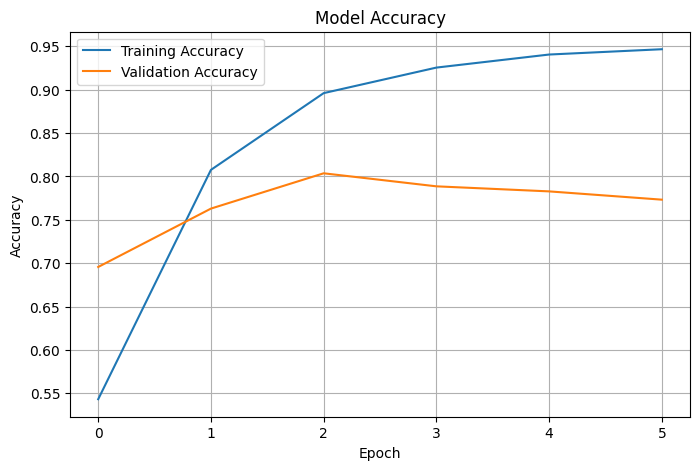

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=200, padding='post')
    pred = model.predict(pad)[0][0]
    return "Positive" if pred > 0.5 else "Negative"

print(predict_sentiment("This movie is amazing!"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Negative


# **Charts**

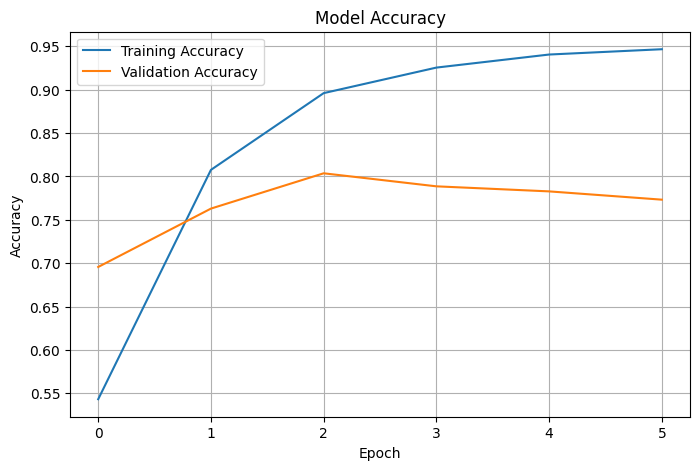

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


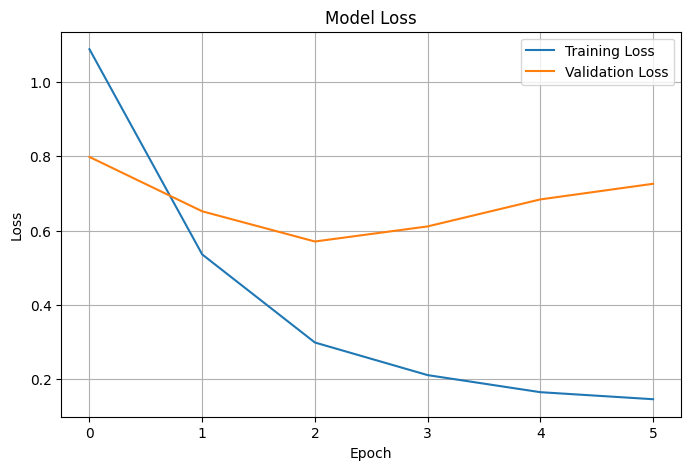

In [58]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


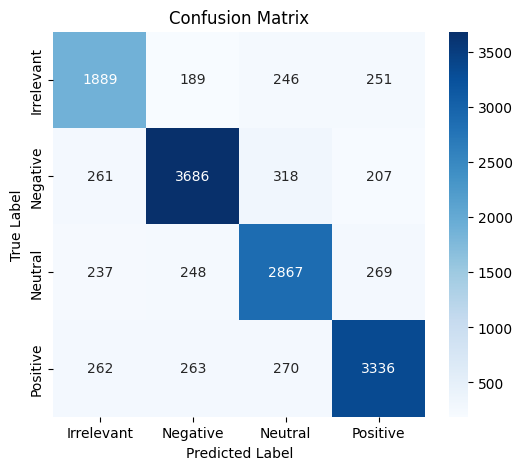

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)

plt.figure(figsize=(7,5))
plt.bar(le.classes_, f1, color=['blue', 'green', 'red'])
plt.title("F1 Score per Class")
plt.ylabel("F1 Score")
plt.xlabel("Label")
plt.show()
